In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## EDA for Segmentation

In [12]:
# Define path variables
TRAIN_CSV = r'Metadata/test.csv'
TEST_CSV = r'Metadata/train.csv'
SEGMENTATION_DIR = r'C:/Users/Snehil Sanyal/Desktop/Papers/O1/database/segmentation/'
TRAIN_DIR = {0: 'Training', 1: 'Testing'}

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
df_seg_train = pd.read_csv(TRAIN_CSV)
df_seg_test = pd.read_csv(TEST_CSV)
df = pd.concat([df_seg_train, df_seg_test])

In [14]:
df.head()

,filenames,img_size_x,img_size_y,masks,gt_size_x,gt_size_y,train_id,seg_dict,is_empty
0,patient101_frame01_slice1.png,232,256,patient101_frame01_gt_slice1.png,232,256,1,"{0: 58064, 170: 491, 255: 837}",0
1,patient101_frame01_slice2.png,232,256,patient101_frame01_gt_slice2.png,232,256,1,"{0: 56801, 85: 874, 170: 567, 255: 1150}",0
2,patient101_frame01_slice3.png,232,256,patient101_frame01_gt_slice3.png,232,256,1,"{0: 56701, 85: 917, 170: 578, 255: 1196}",0
3,patient101_frame01_slice4.png,232,256,patient101_frame01_gt_slice4.png,232,256,1,"{0: 56891, 85: 856, 170: 597, 255: 1048}",0
4,patient101_frame01_slice5.png,232,256,patient101_frame01_gt_slice5.png,232,256,1,"{0: 57044, 85: 738, 170: 574, 255: 1036}",0


In [15]:
df.shape

(2842, 9)

In [16]:
# We have dropped around 75 and 61 images with missing ground truth masks in the training and testing datasets respectively.
df.train_id.value_counts()

train_id
0    1841
1    1001
Name: count, dtype: int64

<Axes: xlabel='train_id'>

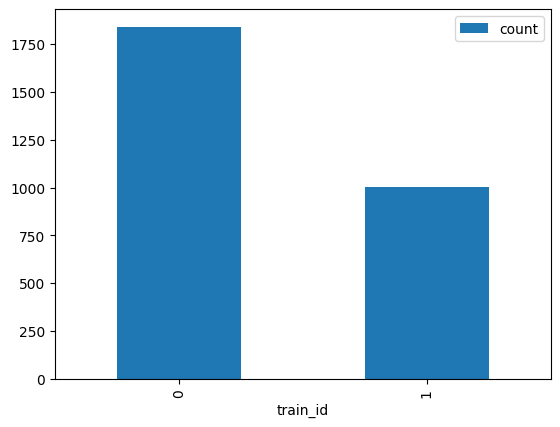

In [17]:
df.train_id.value_counts().plot(kind = 'bar', legend = ['Train', 'Test'])

## Explore the Data

In [18]:
## If we use OpenCV to read images, the png file is being read as 3 dimensional image.
## If we use PIL, it is read as 2 dimensional image.

def generate_sample_images(sample):
    
    imgs = sample.filenames
    train_ids = sample.train_id
    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()
    
    for i, (image_name, train_id) in enumerate(zip(imgs, train_ids)):
        img_path = os.path.join(SEGMENTATION_DIR, TRAIN_DIR[train_id], "Images", image_name)
        image = cv2.imread(img_path)
        print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image.shape)
        ax[i].set_title('{}'.format(image_name))
        ax[i].title.set_size(8)
        ax[i].imshow(image)

def generate_sample_masks(sample):
    
    masks = sample.masks
    train_ids = sample.train_id
    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, (mask_name, train_id) in enumerate(zip(masks, train_ids)):
        mask_path = os.path.join(SEGMENTATION_DIR, TRAIN_DIR[train_id], "Masks", mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("{}".format(mask_name))
        ax[i].title.set_size(8)
        ax[i].imshow(mask, cmap='gray')

(192, 256, 3)
(192, 256, 3)
(216, 256, 3)
(216, 256, 3)
(232, 256, 3)
(232, 256, 3)
(216, 256, 3)
(216, 256, 3)
(256, 208, 3)
(256, 208, 3)


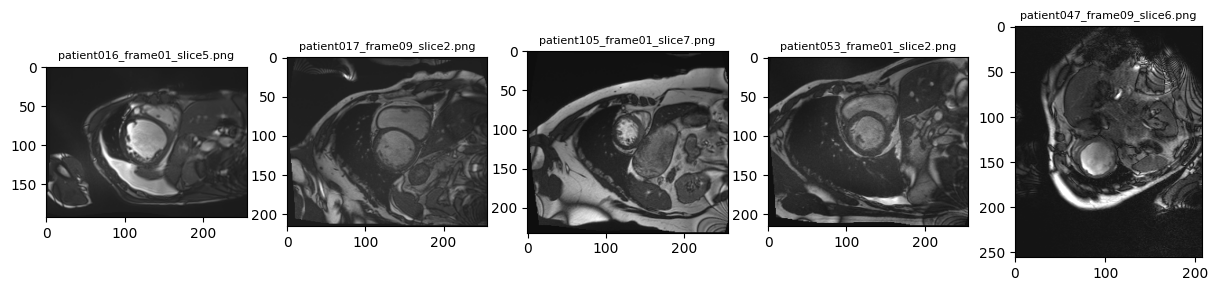

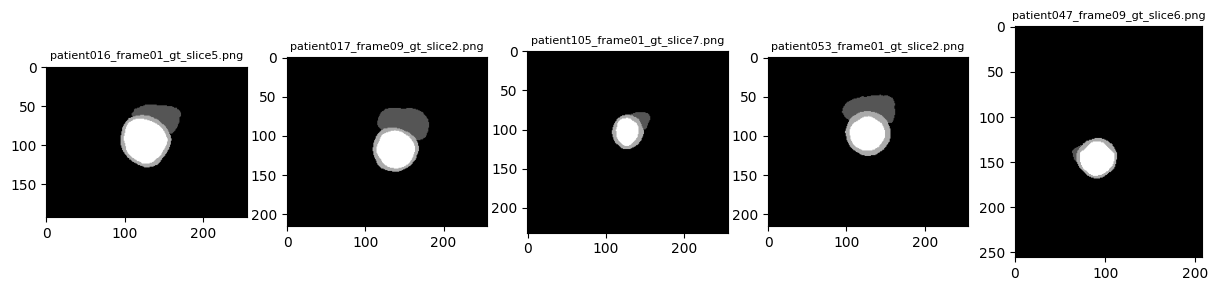

In [19]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]
generate_sample_images(sample)
generate_sample_masks(sample)

After visualization we can see that there are some masks that might be empty, some masks have 3,2, even 1 region. Need to check the mask balance  as well.

**61 masks are empty in Training Set and 75 masks are empty in Testing Set. We will drop these masks during Training.**

## Masks Distribution

## Split the Data

1. Split depending upon the patients (100 Train + 50 Test).
2. Split depending upon the frames (1841 Train + 1001 Test).

1841 Train is split further in Train and Validation.
1001 Test remains same.

In [20]:
df_train = df[(df.train_id == 0) & (df.is_empty == 0)]
df_test = df[(df.train_id == 1) & (df.is_empty == 0)]

In [21]:
# Split df_train in separate train and validation sets
train_df, val_df = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [22]:
train_df.shape, val_df.shape

((1472, 9), (369, 9))

In [23]:
train_df.head()

,filenames,img_size_x,img_size_y,masks,gt_size_x,gt_size_y,train_id,seg_dict,is_empty
588,patient032_frame12_slice2.png,240,256,patient032_frame12_gt_slice2.png,240,256,0,"{0: 60088, 170: 1057, 255: 295}",0
949,patient053_frame01_slice2.png,216,256,patient053_frame01_gt_slice2.png,216,256,0,"{0: 51235, 85: 1509, 170: 1044, 255: 1508}",0
1631,patient091_frame09_slice5.png,180,224,patient091_frame09_gt_slice5.png,180,224,0,"{0: 38833, 85: 646, 170: 393, 255: 448}",0
1719,patient095_frame12_slice3.png,180,224,patient095_frame12_gt_slice3.png,180,224,0,"{0: 37896, 85: 1308, 170: 665, 255: 451}",0
1338,patient076_frame12_slice3.png,256,256,patient076_frame12_gt_slice3.png,256,256,0,"{0: 63249, 85: 1034, 170: 873, 255: 380}",0


## Training Parameters

In [24]:
# Define hyperparameters
EPOCHS = 40        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 224     # Size of image
BATCH_SIZE = 32    # Batch size 

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

## Data Augmentation

In [25]:
import albumentations as A

In [26]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.3), # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p = 0.3),  # Vertical Flip with 0.5 probability
        # A.SquareSymmetry(p = 1.0) (Replace Horizontal and Vertical Flip with Square Symmetry)
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
        A.Affine(scale=(0.95, 1.05), translate_percent=(0.0, 0.05), rotate=(-15, 15), shear=(-5, 5), p=0.5),
        A.RandomBrightnessContrast(brightness_limit= 0.1, contrast_limit= 0.1, p=0.3),
        A.GaussNoise(std_range= (0.1, 0.2), p = 0.2)
    ], is_check_shapes = False)

# Normalize can be done by standardizing to dataset mean and std, or by normalizing to [0, 1] range.

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        #A.Normalize(mean=(0.5,), std=(0.5,)),
    ], is_check_shapes = False)
    
def get_test_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        #A.Normalize(mean=(0.5,), std=(0.5,)),
    ], is_check_shapes=False)

## Processing the Dataset

In [27]:
from torch.utils.data import Dataset

In [28]:
## Create ACDC Dataset for Segmentation

class ACDCSegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df 
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        train_id  = sample.train_id
        if train_id==0:
            FOLDER_NAME = 'Training'
        if train_id==1:
            FOLDER_NAME = 'Testing'
        image_path = os.path.join(SEGMENTATION_DIR, FOLDER_NAME, "Images", sample.filenames)
        mask_path = os.path.join(SEGMENTATION_DIR, FOLDER_NAME, "Masks", sample.masks)

        # Read images and masks (using PIL, which reads images as 2D arrays)
        image =  np.array(Image.open(image_path))
        image = np.expand_dims(image, axis = -1)
        mask = np.array(Image.open(mask_path))
        mask = np.expand_dims(mask, axis = -1)
        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # Transpose Image format in PyTorch Format
        # (H, W, C) --> (C, H, W)
        # Example: (224, 224, 1) --> (1, 224, 224)    
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize the images and masks 
        image = torch.Tensor(image) / 255.

        # Convert mask values [0, 85, 170, 255] → [0, 1, 2, 3]
        mask = torch.Tensor(mask)
        #mask = (mask / 85).long()  

        # mask = torch.round(torch.Tensor(mask))
        mask = torch.round(mask / 85).long()

        return image, mask

In [ ]:
# Processed train and validation data
train_data = ACDCSegmentationDataset(train_df, get_train_augs())
val_data = ACDCSegmentationDataset(val_df, get_val_augs())
test_data = ACDCSegmentationDataset(df_test, get_test_augs())

In [ ]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")
print(f"Size of Testset : {len(test_data)}")

In [ ]:
train_data[0][0].shape, train_data[0][1].shape

In [ ]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image, (1, 2, 0)), cmap = 'gray')
    plt.axis('off')
    plt.title('IMAGE')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(mask, (1, 2, 0)), cmap = 'gray')
    plt.axis('off')
    plt.title('GROUND TRUTH')
    plt.show()

In [ ]:
for i in np.random.randint(0, len(train_data), 20):
    processed_image(i)

## Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valloader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

In [ ]:
for idx, (image, mask) in enumerate(valloader):
    print(f"Size of {idx+1}th batch of images: {image.shape}")
    print(f"Size of {idx+1}th batch of masks: {mask.shape}")

## Create Segmentation Model


**From:** https://smp.readthedocs.io/en/latest/losses.html 

segmentation_models_pytorch.losses.constants.MULTICLASS_MODE: str = 'multiclass'
Loss multiclass mode suppose you are solving multi-class segmentation task. That mean you have C = 1..N classes which have unique label values, classes are mutually exclusive and all pixels are labeled with theese values. Target mask shape - (N, H, W), model output mask shape (N, C, H, W).


## Loss Functions for Medical Image Segmentation
1. Categorical Cross Entropy Loss 
2. Generalized Dice Loss
3. Tversky Loss / Focal Tversky
4. Hybrid Loss (CCE + Dice)

5. Categorical Focal Loss
6. Combination of Focal and Dice Loss
7. 

In [ ]:

import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss, DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name = ENCODER,
            encoder_weights = None,
            in_channels = 1, # 1 Channel for grayscale images
            classes = 4,  # 4 classes
            activation = None)  

    def forward(self, images, masks=None):
        logits = self.model(images)  # (B, 4, H, W)

        if masks is not None:
            # masks should be (B, H, W) with class labels 0-3
            loss1 = DiceLoss(mode = 'multiclass')(logits, masks)
            loss2 = SoftCrossEntropyLoss(smooth_factor=0.0)(logits, masks)
            return logits, loss1 + loss2

        # During Inference I don't want to compute the loss, just the logits will do.
        return logits

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self, model_name='UnetPlusPlus', encoder_name='resnet34', encoder_weights='imagenet',
                 in_channels=1, num_classes=4):
        super(SegmentationModel, self).__init__()

        self.model_name = model_name.lower()
        self.num_classes = num_classes

        # Models from segmentation_models_pytorch
        if self.model_name in ['unet', 'unetplusplus', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3+', 'linknet', 'manet', 'pan']:
            ModelClass = getattr(smp, model_name)
            self.model = ModelClass(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=num_classes,
                activation=None
            )

        # UPerNet, Segformer, DPT from HuggingFace Transformers (or other libs)
        elif self.model_name == 'segformer':
            config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
            config.num_channels = in_channels
            config.num_labels = num_classes
            self.model = SegformerForSemanticSegmentation.from_pretrained(
                "nvidia/segformer-b0-finetuned-ade-512-512",
                config=config
            )

        elif self.model_name == 'upernet' or self.model_name == 'dpt':
            raise NotImplementedError(f"{self.model_name} requires special pre-processing and architecture wrapping.")

        else:
            raise ValueError(f"Model {model_name} not supported.")

    def forward(self, images, masks=None):
        if self.model_name == 'segformer':
            # Segformer expects dict input
            logits = self.model(pixel_values=images).logits  # (B, num_classes, H, W)
        else:
            logits = self.model(images)

        if masks is not None:
            loss1 = DiceLoss(mode='multiclass')(logits, masks)
            loss2 = SoftCrossEntropyLoss(smooth_factor=0.0)(logits, masks)
            return logits, loss1 + loss2

        return logits


In [ ]:
DEVICE

In [ ]:
model = SegmentationModel();
model.to(DEVICE)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params 

## Create Training and Validation Function

In [ ]:
# Function to Train the model (During Training we want logits and loss)
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

## Model Training

In [ ]:
# Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# Training and evaluation loop
best_val_loss = 1e9
tr_loss, va_loss = [], [] 
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)
    tr_loss.append(train_loss)
    va_loss.append(val_loss)
    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

In [ ]:
sns.set(style='white', context='paper', palette='deep')

plt.plot(tr_loss, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.plot(va_loss, marker='s', linestyle='--', color='orange', label='Validation Loss')

plt.title("Train and Validation Loss vs Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(np.arange(0, EPOCHS, 1))

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
sns.set(style='darkgrid', context='paper', palette='deep')

plt.plot(tr_loss, marker='o', linestyle='-', label='Train Loss')
plt.plot(va_loss, marker='o', linestyle='--', label='Validation Loss')

plt.title("Train and Validation Loss vs Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(np.arange(0, EPOCHS, 1))

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params 

## Inference

In [ ]:
test_data[0][0].shape, test_data[0][1].shape

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask (Binary Segmentation, in case of only background and foreground)
def make_inference(idx):
    image, mask = test_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    
    return image, mask, pred_mask

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# New inference function keeping in mind Softmax + Argmax is required for multi class segmentation

def make_inference(idx):
    image, mask = test_data[idx]
    image = image.to(DEVICE).unsqueeze(0)  # (1, C, H, W)
    
    with torch.no_grad():
        logits = model(image)  # (1, 4, H, W)
        probs = torch.softmax(logits, dim=1)  # Convert to probabilities across classes
        pred_mask = torch.argmax(probs, dim=1).squeeze(0)  # (H, W), class labels [0, 1, 2, 3]

    return image.squeeze(0).cpu(), mask, pred_mask.cpu()

## Metrics for Image Segmentation
1. IoU, MeanIoU, Jaccard Metric
2. Dice Coefficient
3. Precision and Recall, F1 Score
4. MAE 
5. Hausdorff Distance
6. Pixel Accuracy, Rand Index


Dice Coefficient, mIOU, Hausdorff Distance, Average Surface Distance.

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(test_data), 5):
    image, mask, pred_mask = make_inference(i)
    
    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)), cmap = 'gray')
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    ## This was with previous inference function.
    # plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    # After new inference function
    plt.imshow(np.transpose(np.transpose(pred_mask)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

In [ ]:
tr_loss

In [ ]:
va_loss

In [ ]:
image.shape, mask.shape, pred_mask.shape

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be 

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.